# Imports and setup

In [43]:
!pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 7.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]/2 [kagglehub]


 43%|████▎     | 48.0M/112M [00:02<00:03, 17.8MB/s]


KeyboardInterrupt: 

In [5]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time




In [6]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [7]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [8]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset

In [9]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [10]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=True)


Building dataset 



# Data Augmentation

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


# Paramètres

In [12]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.93359375
Max pixel value: 0.98046875
Mean pixel value: -0.12004666775465012


train samples: 67, test samples: 20, nb_classes: 10
train Class 0: 8 samples
train Class 1: 7 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 6 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 2 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


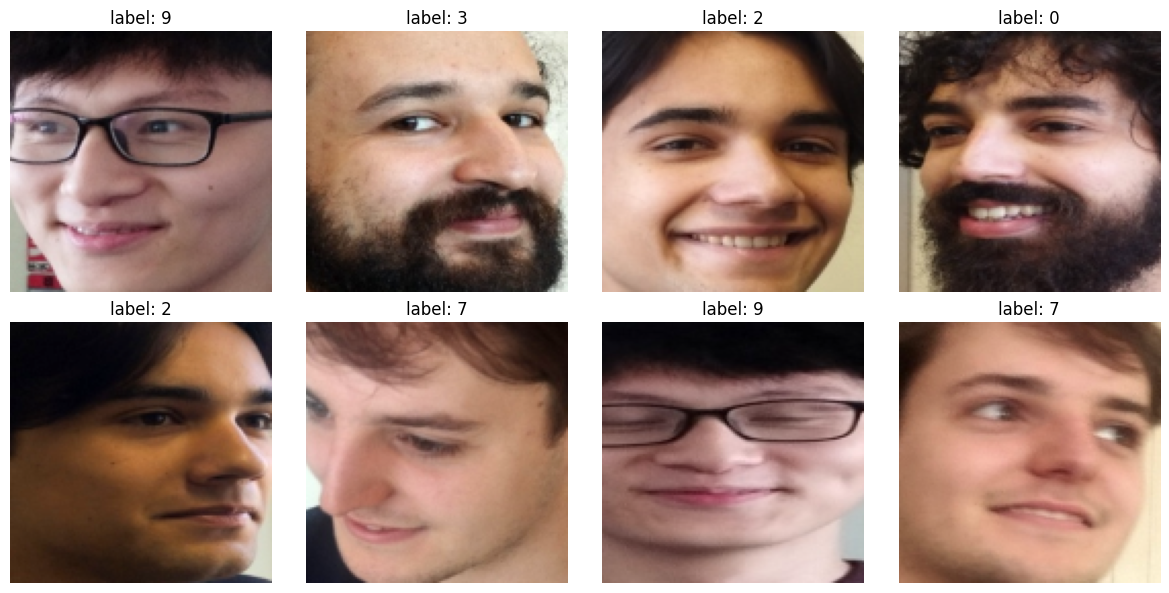

In [15]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [16]:


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 *32*32, EMBEDDING_SIZE )

    def forward(self,x):
        res = self.conv(x)
        res = torch.flatten(res,1)
        res = self.fc(res)
        res = res / res.norm(dim= 1, keepdim=True).clamp(min=1e-6) # normalise la sortie, donne de meilleur resultat
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [17]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


Embedder has 2098720 parameters
Epoch 1, Training Loss: 0.7638, Validation Loss: 1.0267
Epoch 2, Training Loss: 0.7335, Validation Loss: 1.0220
Epoch 3, Training Loss: 0.7144, Validation Loss: 1.0192
Epoch 4, Training Loss: 0.7085, Validation Loss: 1.0188
Epoch 5, Training Loss: 0.6925, Validation Loss: 1.0204
Epoch 6, Training Loss: 0.9932, Validation Loss: 1.0228
Epoch 7, Training Loss: 0.9857, Validation Loss: 1.0263
Epoch 8, Training Loss: 0.6647, Validation Loss: 1.0273
Epoch 9, Training Loss: 0.6565, Validation Loss: 1.0291
Epoch 10, Training Loss: 0.6462, Validation Loss: 1.0306
Epoch 11, Training Loss: 0.6498, Validation Loss: 1.0301
Epoch 12, Training Loss: 0.9323, Validation Loss: 1.0266
Epoch 13, Training Loss: 0.6230, Validation Loss: 1.0259
Epoch 14, Training Loss: 0.6083, Validation Loss: 1.0247
Epoch 15, Training Loss: 0.6184, Validation Loss: 1.0215
Epoch 16, Training Loss: 0.6185, Validation Loss: 1.0182
Epoch 17, Training Loss: 0.7552, Validation Loss: 1.0145
Epoch 18

In [18]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

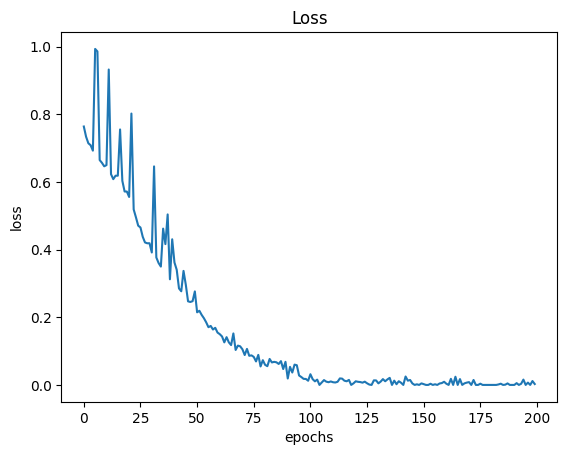

In [19]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [20]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [0.14181203301995993, -0.05891713174059987, -0.08881347253918648, -0.02647552062990144, 0.053285073256120086, -0.020072690851520747, 0.03883105027489364, 0.13037841487675905, -0.07725734123960137, -0.1386263333261013, 0.04458297952078283, -0.14462878368794918, 0.07683847332373261, -0.09093526937067509, 0.02130652847699821, -0.1037483736872673, 0.00621596522978507, -0.018338997091632336, -0.04937837994657457, 0.041163847548887134, 0.03547172260005027, -0.1353689283132553, -0.006924201967194676, -0.047996849520131946, 0.12673256266862154, -0.12627011444419622, 0.04641119297593832, 0.0069226923151290976, -0.11675924248993397, -0.07315853238105774, -0.09136828035116196, -0.17472281493246555, 0.09211654402315617, -0.008875347462890204, -0.11963604297488928, -0.08040890470147133, 0.09310914808884263, -0.025671478069853038, 0.03258160895711626, 0.10501579847186804, -0.03687570564216003, 0.04766810010187328, -0.03239877559826709, -0.06996850436553359, -0.1502510290592

In [21]:
import math

faceEmbedder.eval()

correct = 0
total = 0
avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min == labels[0].item():
            correct += 1

        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0 
print(f"accuracy: {accuracy:.4f}, {correct} / {total}")


accuracy: 0.9000, 18 / 20


/tmp/ipykernel_5830/3697995146.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  avg_embeddings = torch.Tensor(avg_embeddings).to(device)


### Plot embeddings

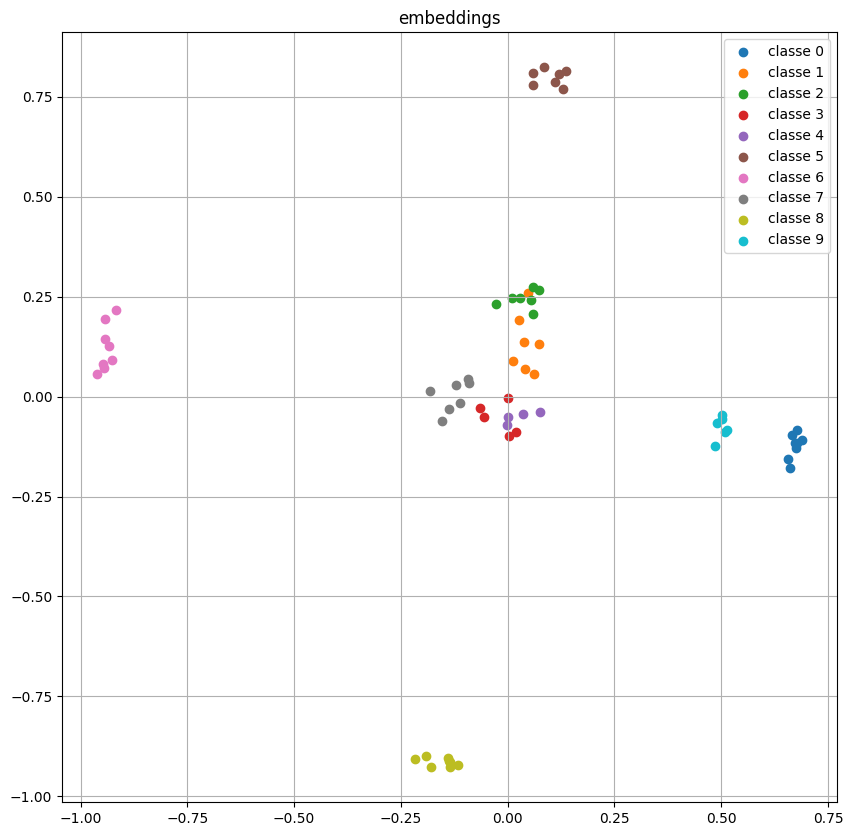

In [22]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [23]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(1000):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.3051, test loss: 2.3075
Epoch 2, training loss: 2.2999, test loss: 2.3000
Epoch 3, training loss: 2.2823, test loss: 2.2927
Epoch 4, training loss: 2.2696, test loss: 2.2854
Epoch 5, training loss: 2.2663, test loss: 2.2784
Epoch 6, training loss: 2.2863, test loss: 2.2714
Epoch 7, training loss: 2.2424, test loss: 2.2645
Epoch 8, training loss: 2.2195, test loss: 2.2577
Epoch 9, training loss: 2.2153, test loss: 2.2509
Epoch 10, training loss: 2.2055, test loss: 2.2441
Epoch 11, training loss: 2.2088, test loss: 2.2374
Epoch 12, training loss: 2.1956, test loss: 2.2306
Epoch 13, training loss: 2.1685, test loss: 2.2238
Epoch 14, training loss: 2.1917, test loss: 2.2170
Epoch 15, training loss: 2.1566, test loss: 2.2102
Epoch 16, training loss: 2.1585, test loss: 2.2034
Epoch 17, training loss: 2.1504, test loss: 2.1967
Epoch 18, training loss: 2.1296, test loss: 2.1900
Epoch 19, training loss: 2.1254, test loss: 2.1833
Epoch 20, training loss: 2.1233, test lo

## Analyse

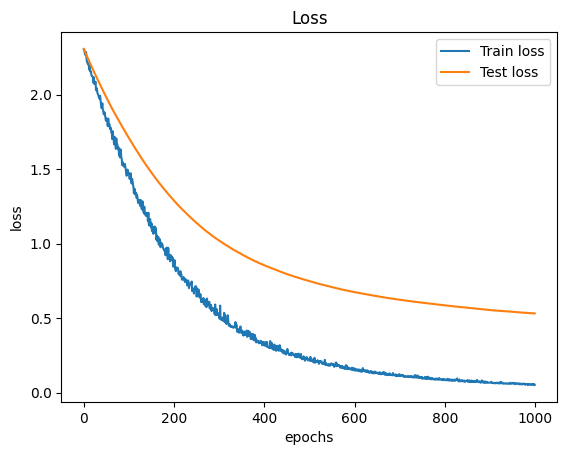

In [24]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

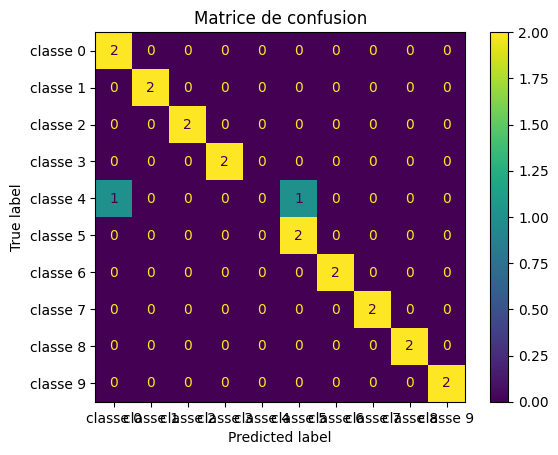

accuracy on test set: 90.00% (18/20)


In [25]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

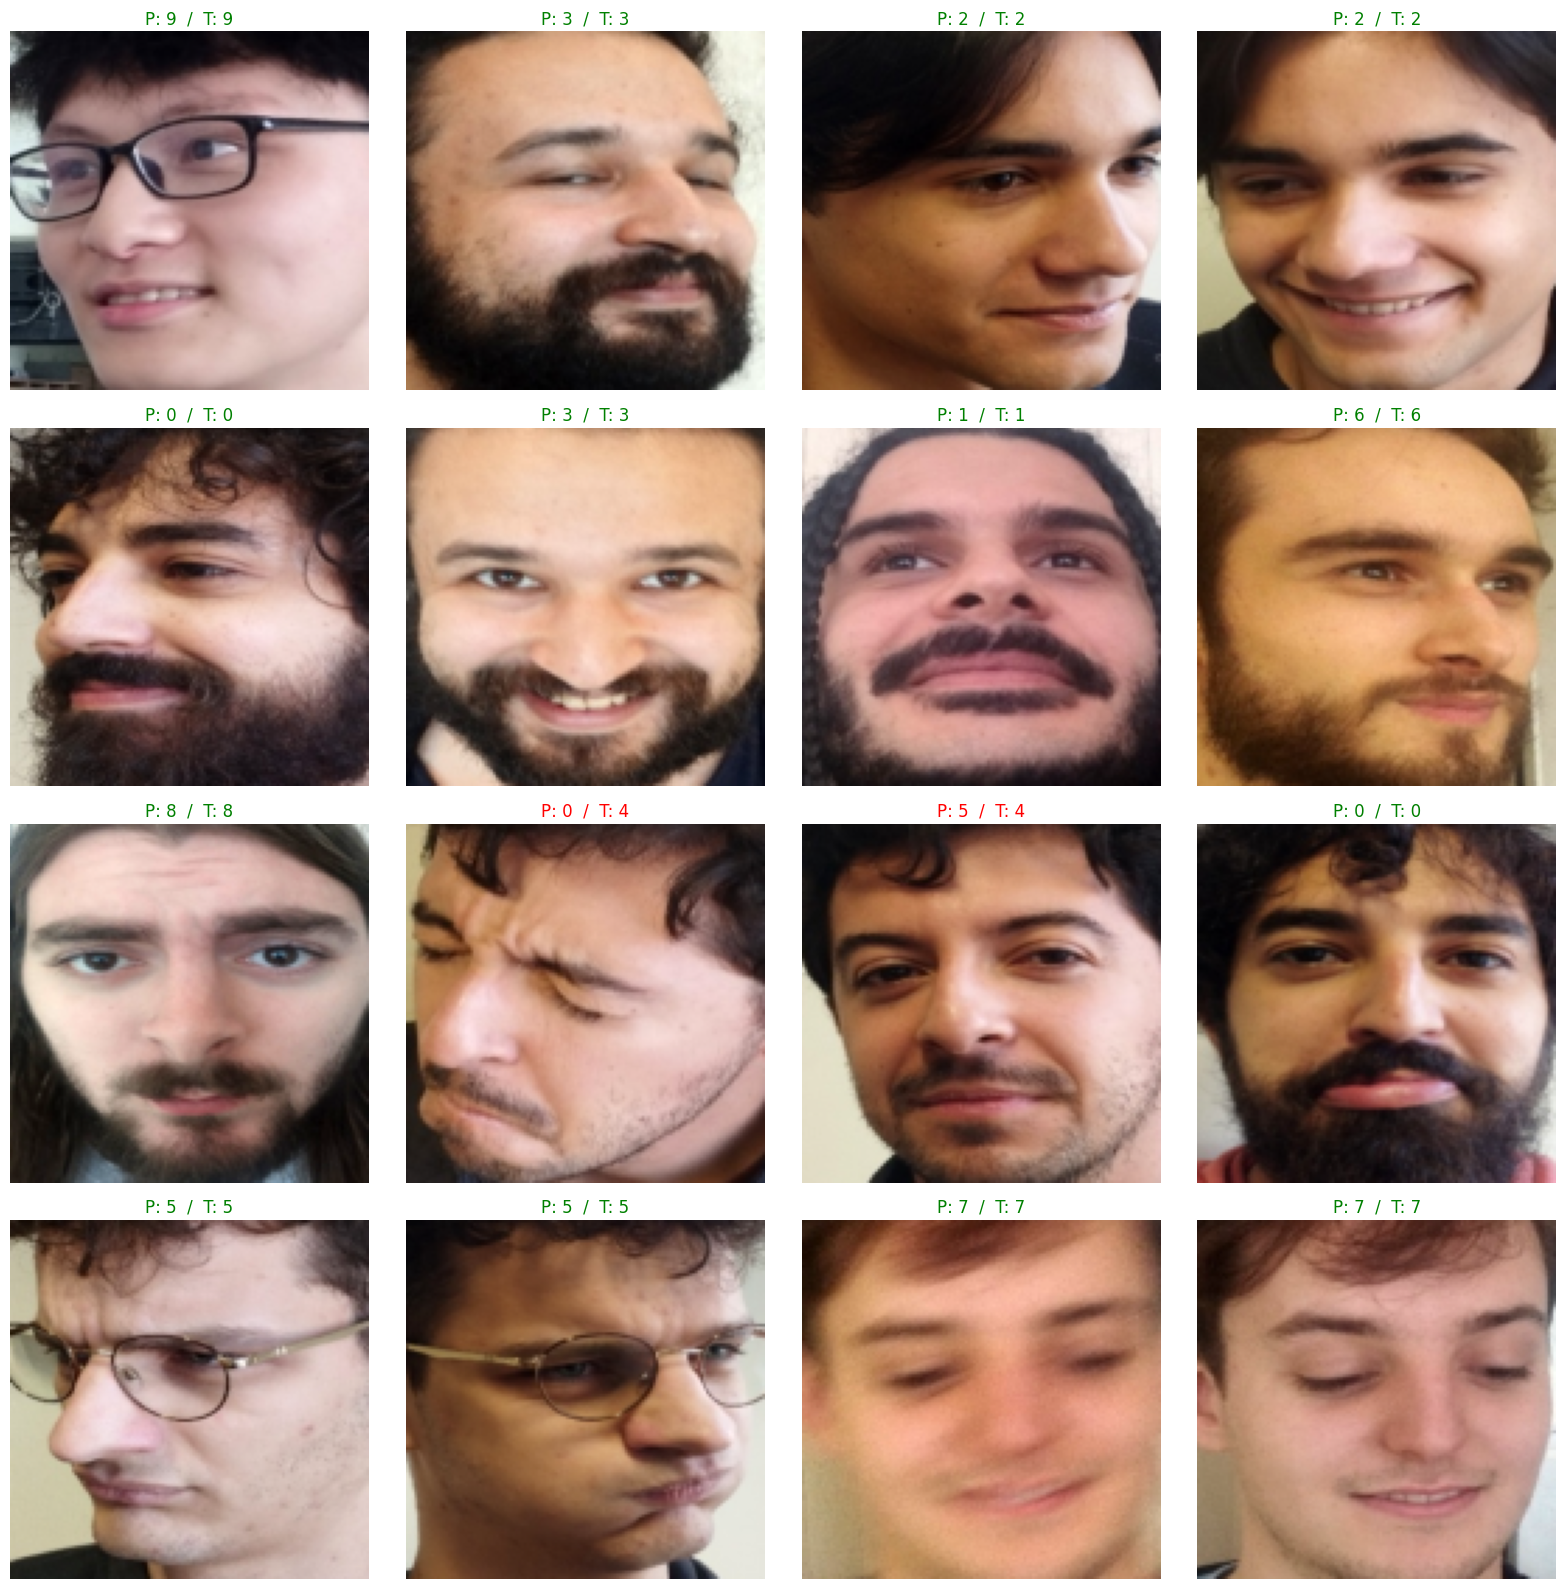

In [26]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# VAE

In [27]:

EMBEDDING_SIZE = 128

class VAE(nn.Module):
    def __init__(self, embedding = 128):
        super().__init__()
        self.embedding = embedding
        self.max_feature = 16
        self.img_size = 32
        self.flattened_size = self.max_feature * self.img_size * self.img_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1, ), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille

            nn.Conv2d(8,16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )


        self.fc_decode = nn.Linear(self.embedding, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )


        self.fc_mu = nn.Linear(self.flattened_size, self.embedding )
        self.fc_logvar = nn.Linear(self.flattened_size, self.embedding )

    def encode(self, x):
        encoded = self.encoder(x)
        f = torch.flatten(encoded,1)
        mean = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self,x):
        mean,logvar = self.encode(x)

        z = self.reparametrize(mean,logvar)
        
        h = self.fc_decode(z)
        

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res, mean, logvar
    
    def random(self):

        z = torch.randn((1, self.embedding), device=next(self.parameters()).device)

        h = self.fc_decode(z)

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res







## Entrainement autoencoder complet

In [28]:
autoencoder = VAE().to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.00

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params} parameters")

beta = 1.0

def elbo_loss(recon, x, mean, logvar):
    #lpi_loss = lpipsLoss(recon, x).mean() * lpips_factor 
    recon_loss = (F.l1_loss(recon, x, reduction='sum') )/x.size(0) 
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss , recon_loss, beta * kl_loss

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/e20210000275/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 104MB/s]  


Loading model from: /home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
VAE has 6311979 parameters


In [29]:

#checkpoint_path = "autoencoder_epoch_300.pth"
#autoencoder.load_state_dict(torch.load(checkpoint_path))
#autoencoder.eval()

In [30]:
epochs = 250

eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        z ,recon, mean, logvar = autoencoder(images)

        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean,logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        z ,recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean,logvar)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        #torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")
        pass

0s
Epoch 1, training loss: 21778.5065, test loss: 17545.9004
1m 29s
Epoch 2, training loss: 21479.0977, test loss: 17512.4648
47s
Epoch 3, training loss: 20464.0286, test loss: 17482.0703
33s
Epoch 4, training loss: 19715.9954, test loss: 17490.7598
26s
Epoch 5, training loss: 18536.9948, test loss: 17453.0156
22s
Epoch 6, training loss: 17881.2533, test loss: 17535.7441
19s
Epoch 7, training loss: 18166.1908, test loss: 17555.3418
17s
Epoch 8, training loss: 18169.7585, test loss: 17601.6641
16s
Epoch 9, training loss: 17079.2432, test loss: 17606.0137
14s
Epoch 10, training loss: 18254.8776, test loss: 17564.2480
13s
Epoch 11, training loss: 17435.2357, test loss: 17338.1816
13s
Epoch 12, training loss: 17534.6582, test loss: 17081.2988
12s
Epoch 13, training loss: 16558.1055, test loss: 17241.8047
11s
Epoch 14, training loss: 17092.9375, test loss: 16390.0840
11s
Epoch 15, training loss: 15424.4271, test loss: 16722.1777
10s
Epoch 16, training loss: 16189.6048, test loss: 16585.4375

### Analyse

#### Loss

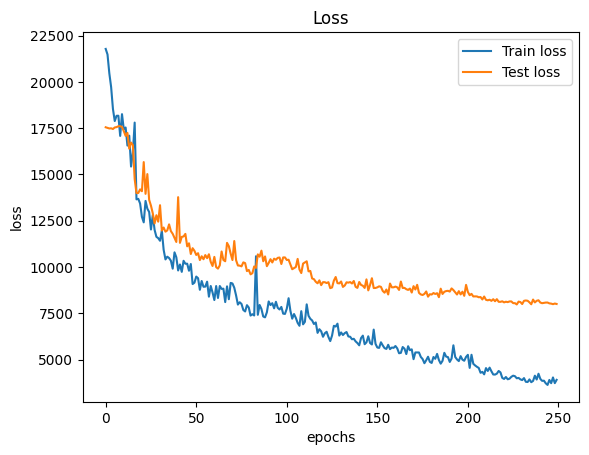

In [31]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

#### Encoder

classe 0: avg embedding = [-0.005300089716911316, -1.1076052859425545, -0.1687398860231042, -1.3115894794464111, 3.745411150623113, 0.5664185658097267, 0.7125043421983719, 0.46219863928854465, -0.33557987958192825, -0.4777698814868927, -0.5156704969704151, -2.1017862781882286, -0.134975865483284, -2.2185642793774605, 1.396587960422039, -3.813068062067032, -3.133542574942112, -0.7580635063350201, -1.024784378707409, 0.1399596557021141, 3.2831861525774, -0.10462115611881018, 1.4051634296774864, -1.6706580556929111, 0.5105749405920506, -0.9116339683532715, 0.24359965417534113, -1.4806551225483418, -0.026907067745923996, 3.5854417867958546, -0.1614095401018858, -1.870856400579214, -1.2609606832265854, -2.038821429014206, 0.7158462917432189, 0.5723988711833954, -2.2089888602495193, -0.5230399742722511, -0.2966347485780716, 1.398177731782198, 0.6416897624731064, -1.1023236364126205, 2.8581193685531616, 2.159583203494549, -0.7523011141456664, -0.8957392871379852, 1.6378277391195297, 2.1007569

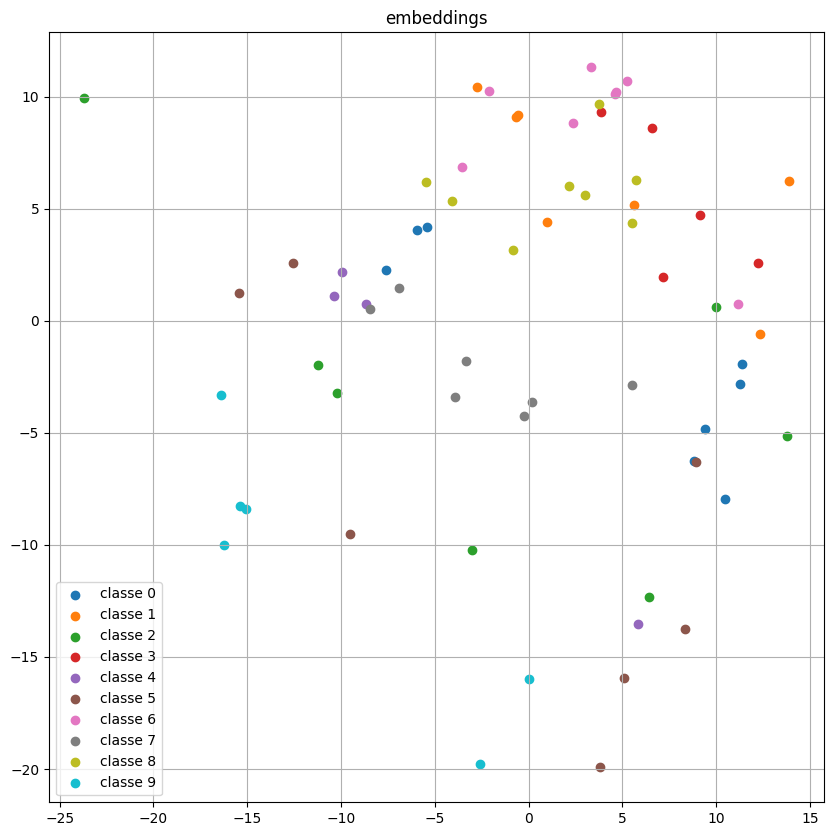

In [32]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output,_,_ = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

#### Decoder

#### Sur jeu d'entrainement

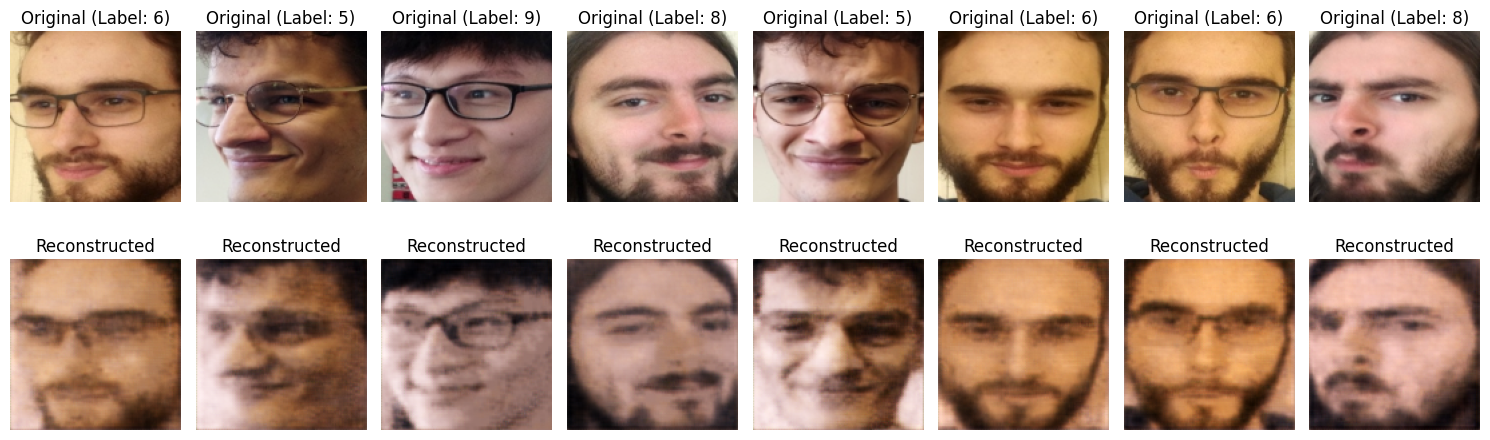

In [33]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Sur jeu de test

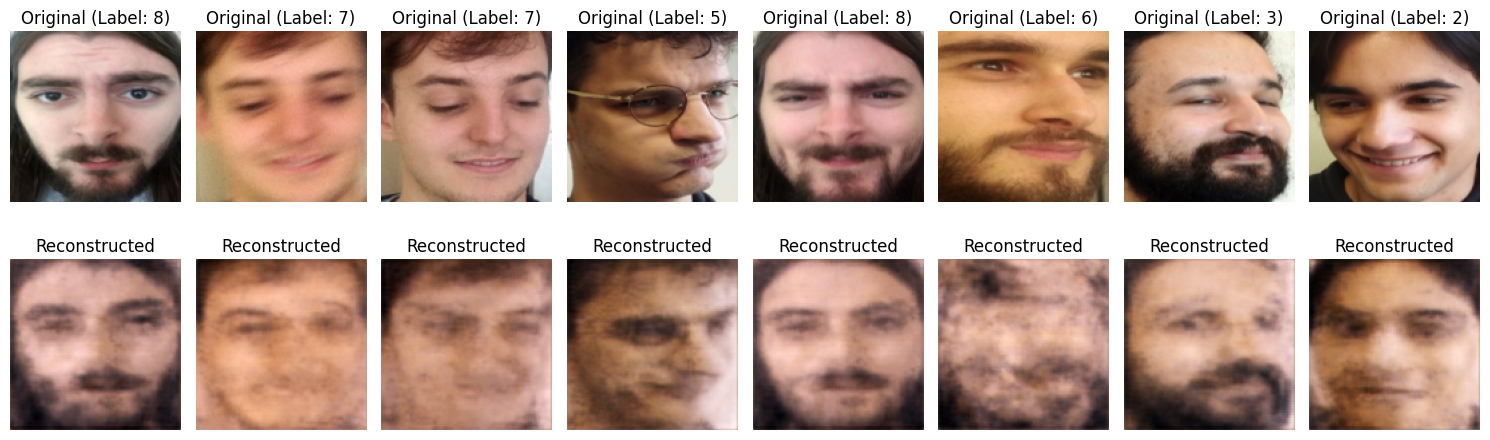

In [34]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

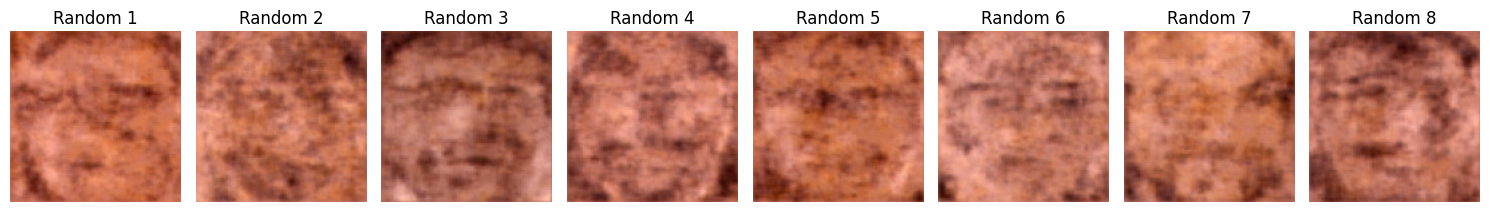

In [35]:
autoencoder.eval()

reconstructed_images = []

with torch.no_grad():
    for _ in range(8):
        _, img = autoencoder.random()
        reconstructed_images.append(img)

reconstructed_images = torch.cat(reconstructed_images, dim=0)

n = reconstructed_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[i].imshow(recon_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Random {i+1}")

plt.tight_layout()
plt.show()


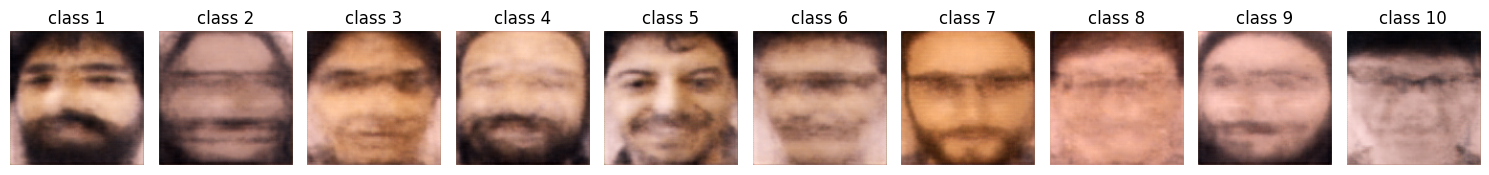

In [36]:
autoencoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device, dtype=torch.float32)

random_embeddings = random_embeddings.to(device)

decoder_only = autoencoder.decoder.eval()

with torch.no_grad():
    #un = random_embeddings.unflatten(1, (EMBEDDING_SIZE, 1, 1))
    #generated_images = autoencoder.decoder(random_embeddings)

    h = autoencoder.fc_decode(random_embeddings)
    h = h.view(-1, autoencoder.max_feature, autoencoder.img_size, autoencoder.img_size)
    generated_images = autoencoder.decoder(h)
    

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"class {i+1}")

plt.tight_layout()
plt.show()

#### HYPER LOOP

In [37]:
from itertools import product

learning_rates = [0.0001, 0.001]
betas = [0.5, 1.0, 2.0]
lpips_factors = [0.0]
batch_sizes = [4,8,16, 32]
weight_decays = [0.0]
latent_sizes = [32,64,128]
epochs = 250

total_models = len(learning_rates) * len(betas) * len(lpips_factors) * len(batch_sizes) * len(weight_decays) * len(latent_sizes)
i = 0

for lr, beta, lpips_factor, batch_size, weight_decay, latent_s in product(learning_rates, betas, lpips_factors, batch_sizes, weight_decays, latent_sizes):
    #print(f"Training VAE with lr={lr}, beta={beta}, lpips_factor={lpips_factor}, batch_size={batch_size}, weight_decay={weight_decay}")
    
    autoencoder = VAE(latent_s).to(device)

    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def elbo_loss(recon, x, mean, logvar):
        recon_loss = (F.l1_loss(recon, x, reduction='sum') / x.size(0)) #+ lpipsLoss(recon, x).mean() * lpips_factor
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
        return recon_loss + beta * kl_loss, recon_loss, beta * kl_loss

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            z, recon, mean, logvar = autoencoder(images)
            loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    model_name = f"models/vae_lr{lr}_beta{beta}_lpips{lpips_factor}_bs{batch_size}_ls{latent_s}.pth"
    torch.save(autoencoder.state_dict(), model_name)
    print(f"model saved {model_name} ")
    
    print(f"{i}/{total_models}")
    i+=1

model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs4_ls32.pth 
0/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs4_ls64.pth 
1/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs4_ls128.pth 
2/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs8_ls32.pth 
3/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs8_ls64.pth 
4/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs8_ls128.pth 
5/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs16_ls32.pth 
6/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs16_ls64.pth 
7/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs16_ls128.pth 
8/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs32_ls32.pth 
9/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs32_ls64.pth 
10/72
model saved models/vae_lr0.0001_beta0.5_lpips0.0_bs32_ls128.pth 
11/72
model saved models/vae_lr0.0001_beta1.0_lpips0.0_bs4_ls32.pth 
12/72
model saved models/vae_lr0.0001_beta1.0_lpips0.0_bs4_ls64.pth 
13/72
model saved models/vae_lr0.0001_be

In [ ]:
import re

model_dir = "models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

for model_file in model_files:
    print(f"testing model: {model_file}")
    
    latent_size_match = re.search(r'_ls(\d+)', model_file)
    if latent_size_match:
        latent_size = int(latent_size_match.group(1))
    else:
        print(f"Could not extract latent size from filename: {model_file}")
        continue
    
    autoencoder = VAE(embedding=latent_size).to(device)
    model_path = os.path.join(model_dir, model_file)
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()
    
    total_loss = 0.0
    reconstructed_images = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _, recon, mean, logvar = autoencoder(images)
            loss, _, _ = elbo_loss(recon, images, mean, logvar)
            total_loss += loss.item()
            reconstructed_images.append(recon.cpu())
    
    avg_loss = total_loss / len(test_loader)
    print(f"avg loss on test set: {avg_loss:.4f}")
    
    reconstructed_images = torch.cat(reconstructed_images, dim=0)
    n = min(8, reconstructed_images.size(0))
    fig, axs = plt.subplots(2, n, figsize=(15, 5))
    
    for i in range(n):
        original_img = images[i].permute(1, 2, 0).cpu().numpy()
        recon_img = reconstructed_images[i].permute(1, 2, 0).numpy()
        
        mi, ma = original_img.min(), original_img.max()
        original_disp = (original_img - mi) / (ma - mi) if ma - mi > 1e-6 else original_img
        
        mi, ma = recon_img.min(), recon_img.max()
        recon_disp = (recon_img - mi) / (ma - mi) if ma - ma > 1e-6 else recon_img
        
        axs[0, i].imshow(original_disp)
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")
        
        axs[1, i].imshow(recon_disp)
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    del autoencoder
    torch.cuda.empty_cache()


##     Entrainement du decodeur uniquement avec un embedder deja entraine

In [39]:
decoder = Decoder().to(device)
L1loss = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(100):
    total_loss = 0.0
    decoder.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)
        #print(images.size())

        output = decoder(embeded)
        #print(output.size())

        loss = L1loss(output, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    decoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = decoder(embeded)
        loss = L1loss(output, images)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



Epoch 1, training loss: 0.1742, test loss: 0.1978
Epoch 2, training loss: 0.1957, test loss: 0.1977
Epoch 3, training loss: 0.1878, test loss: 0.1975
Epoch 4, training loss: 0.1966, test loss: 0.1973
Epoch 5, training loss: 0.2003, test loss: 0.1971
Epoch 6, training loss: 0.2179, test loss: 0.1969
Epoch 7, training loss: 0.1869, test loss: 0.1967
Epoch 8, training loss: 0.1947, test loss: 0.1965
Epoch 9, training loss: 0.1854, test loss: 0.1963
Epoch 10, training loss: 0.1855, test loss: 0.1961
Epoch 11, training loss: 0.1913, test loss: 0.1959
Epoch 12, training loss: 0.1944, test loss: 0.1957
Epoch 13, training loss: 0.1780, test loss: 0.1955
Epoch 14, training loss: 0.2034, test loss: 0.1953
Epoch 15, training loss: 0.1856, test loss: 0.1951
Epoch 16, training loss: 0.1751, test loss: 0.1949
Epoch 17, training loss: 0.1825, test loss: 0.1947
Epoch 18, training loss: 0.2052, test loss: 0.1945
Epoch 19, training loss: 0.2007, test loss: 0.1942
Epoch 20, training loss: 0.1956, test lo

### Analyse

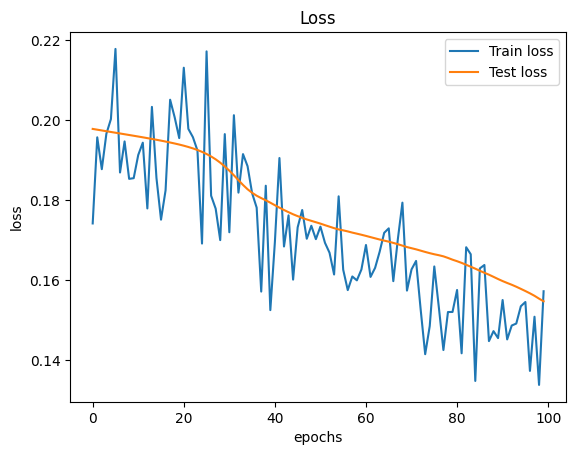

In [40]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

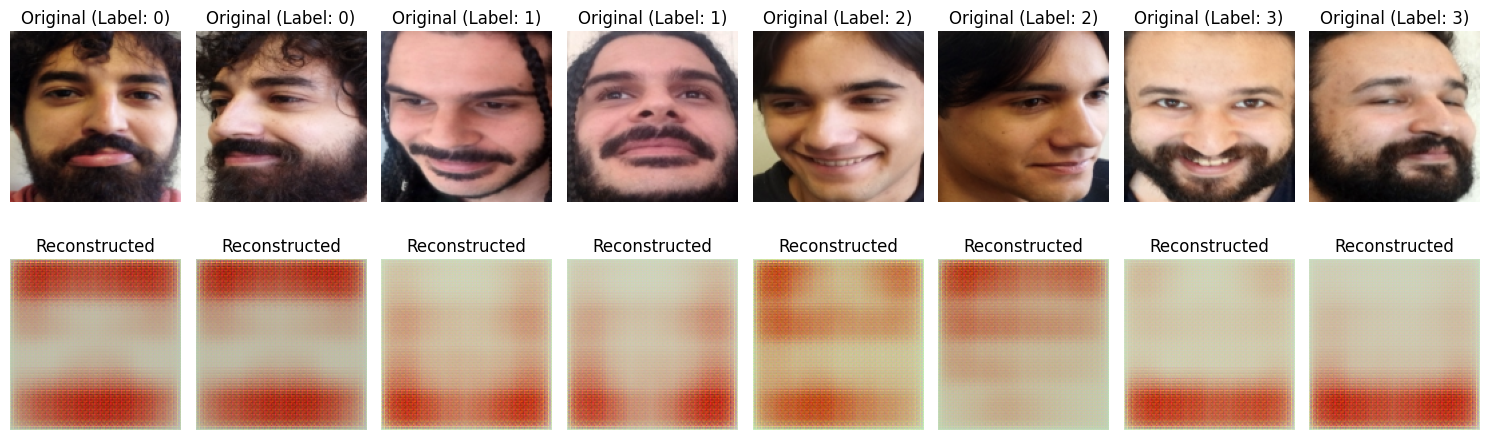

In [41]:
decoder.eval()
faceEmbedder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    embeddings = faceEmbedder(images)

    reconstructed_images = decoder(embeddings)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

### Reconstruction de la moyenne des embeddings de chaque classe

avg_embeddings type/shape: <class 'list'> (10, 128)
random_embeddings: torch.Size([10, 128]) torch.float32 cuda:0


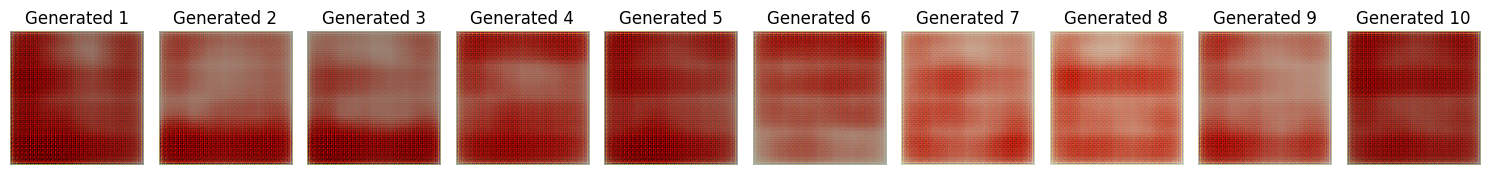

In [42]:
decoder.eval()

print("avg_embeddings type/shape:", type(avg_embeddings), np.array(avg_embeddings).shape)

random_embeddings = torch.tensor(avg_embeddings, dtype=torch.float32, device=device)
print("random_embeddings:", random_embeddings.shape, random_embeddings.dtype, random_embeddings.device)

with torch.no_grad():
    generated_images = decoder(random_embeddings)

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Generated {i+1}")

plt.tight_layout()
plt.show()

## Essais avec un plus gros dataset

In [46]:
#importer dataset kaggle
import kagglehub
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

Resuming download from 50331648 bytes (67564007 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/jessicali9530/lfw-dataset?dataset_version_number=4 (50331648/117895655) bytes left.


100%|██████████| 112M/112M [00:03<00:00, 21.6MB/s] 

Extracting files...
